In [1]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import os
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

In [2]:
from google.colab import drive
# connect the google drive to you colab for data acess
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 1. Dataset Class
class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.image_files[idx])  # Assume masks have the same filenames

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),    # Random vertical flip
    transforms.RandomRotation(10),      # Random rotation up to 10 degrees
    transforms.ToTensor()
])

# Load Dataset
image_dir = "/content/drive/MyDrive/Breast Cancer Detection/DataSet for Segmentation Training & Testing/original"
mask_dir = "/content/drive/MyDrive/Breast Cancer Detection/DataSet for Segmentation Training & Testing/Mask"
dataset = MedicalImageDataset(image_dir, mask_dir, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [4]:
# Enhanced Data Augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to uniform dimensions
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.5),    # Random vertical flip
    transforms.RandomRotation(15),           # Random rotation up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jittering
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Gaussian blur
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize to ImageNet standards
])


In [5]:
# 2. Build Hybrid Model
def build_unet_encoder(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    return tf.keras.Model(inputs, [c1, c2, c3])

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Add BatchNorm here
            nn.ReLU(),
            nn.Dropout(0.3),  # Add Dropout here
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Add BatchNorm here
            nn.ReLU(),
        )
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Add BatchNorm here
            nn.ReLU(),
            nn.Dropout(0.3),  # Add Dropout here
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Add BatchNorm here
            nn.ReLU(),
        )
        self.final = nn.Conv2d(64, 1, kernel_size=1)
    def forward(self, features):
        c1, c2, c3 = features
        x = self.up1(c3)
        x = torch.cat([x, c2], dim=1)
        x = self.conv1(x)
        x = self.up2(x)
        x = torch.cat([x, c1], dim=1)
        x = self.conv2(x)
        return self.final(x)

# Convert TensorFlow tensors to PyTorch tensors
def tf_to_torch(tf_tensor):
    np_array = tf_tensor.numpy()
    return torch.tensor(np_array).permute(0, 3, 1, 2)

# Initialize Hybrid Model
encoder = build_unet_encoder(input_shape=(256, 256, 3))
decoder = Decoder()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(decoder.parameters(), lr=1e-3, weight_decay=1e-4)

In [6]:
best_val_loss = float('inf')
patience = 5
counter = 0

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

for epoch in range(10):  # Increased epoch limit to accommodate slower learning with regularization
    decoder.train()
    total_loss = 0
    for images, masks in train_loader:
        tf_features = encoder(images.permute(0, 2, 3, 1).numpy())
        torch_features = [tf_to_torch(f) for f in tf_features]
        predictions = decoder(torch_features)

        # Add Gaussian noise to predictions for robustness
        predictions += torch.normal(0, 0.1, size=predictions.size())

        loss = criterion(predictions, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation step
    decoder.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in test_loader:
            tf_features = encoder(images.permute(0, 2, 3, 1).numpy())
            torch_features = [tf_to_torch(f) for f in tf_features]
            predictions = decoder(torch_features)
            loss = criterion(predictions, masks)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader)}, Val Loss: {val_loss}")

    # Step the learning rate scheduler
    scheduler.step(val_loss)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset counter if validation loss improves
    else:
        counter += 1
        if counter >= patience:  # Stop if validation loss doesn't improve for `patience` epochs
            print("Early stopping triggered")
            break

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 0.3344692351489231, Val Loss: 0.12020740006119013
Epoch 2, Train Loss: 0.14111369385801512, Val Loss: 0.14729960821568966
Epoch 3, Train Loss: 0.07834939504491872, Val Loss: 0.06253828993067145
Epoch 4, Train Loss: 0.04947437178985826, Val Loss: 0.04744375217705965
Epoch 5, Train Loss: 0.03379490894490275, Val Loss: 0.02892463724128902
Epoch 6, Train Loss: 0.024505600975505238, Val Loss: 0.022041549673303962
Epoch 7, Train Loss: 0.01860675376293988, Val Loss: 0.018656387692317367
Epoch 8, Train Loss: 0.01456713265386121, Val Loss: 0.013695764355361462
Epoch 9, Train Loss: 0.011749229458128584, Val Loss: 0.012595490436069667
Epoch 10, Train Loss: 0.00966972369572212, Val Loss: 0.0094117212574929


In [7]:
torch.save(decoder.state_dict(), "best_model.pth")

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Initialize lists to store predictions and ground truths
all_preds = []
all_targets = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best model for evaluation
decoder.load_state_dict(torch.load("best_model.pth"))

decoder.to(device) # Move the decoder to the selected device


decoder.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        # Extract features using the encoder
        tf_features = encoder(images.permute(0, 2, 3, 1).cpu().numpy())

        # Convert TensorFlow tensors to PyTorch tensors correctly
        torch_features = [torch.from_numpy(f.numpy()).permute(0, 3, 1, 2).to(device) if len(f.shape) > 0 else torch.tensor(f.numpy(), device=device) for f in tf_features]

        # Get model predictions
        predictions = decoder(torch_features)

        # Apply thresholding
        preds = (predictions > 0.5).float()

        # Flatten for metric computation
        all_preds.extend(preds.cpu().numpy().flatten())
        all_targets.extend(masks.cpu().numpy().flatten())

# Convert lists to numpy arrays and ensure they are binary
all_preds = np.array(all_preds).astype(int)  # Convert to integers (0 or 1)
all_targets = np.array(all_targets).astype(int)  # Convert to integers (0 or 1)

# Calculate metrics
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, zero_division=1)
recall = recall_score(all_targets, all_preds, zero_division=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

<ipython-input-8-65bcb13e158a>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load("best_model.pth"))


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


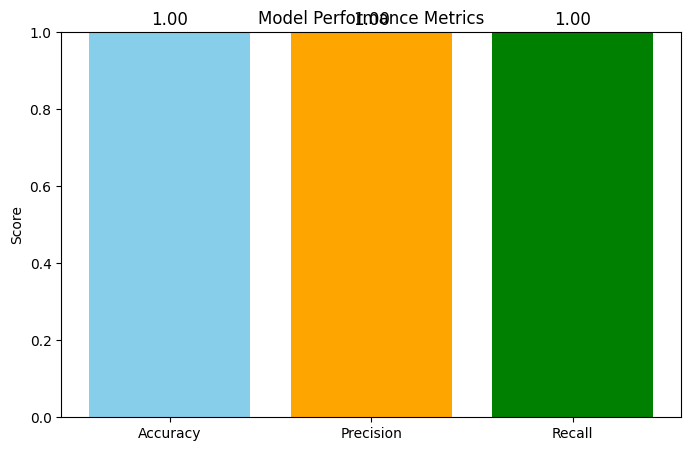

In [9]:
import matplotlib.pyplot as plt

# Plot the metrics
metrics = ['Accuracy', 'Precision', 'Recall']
values = [accuracy, precision, recall]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['skyblue', 'orange', 'green'])
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Model Performance Metrics')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)
plt.show()

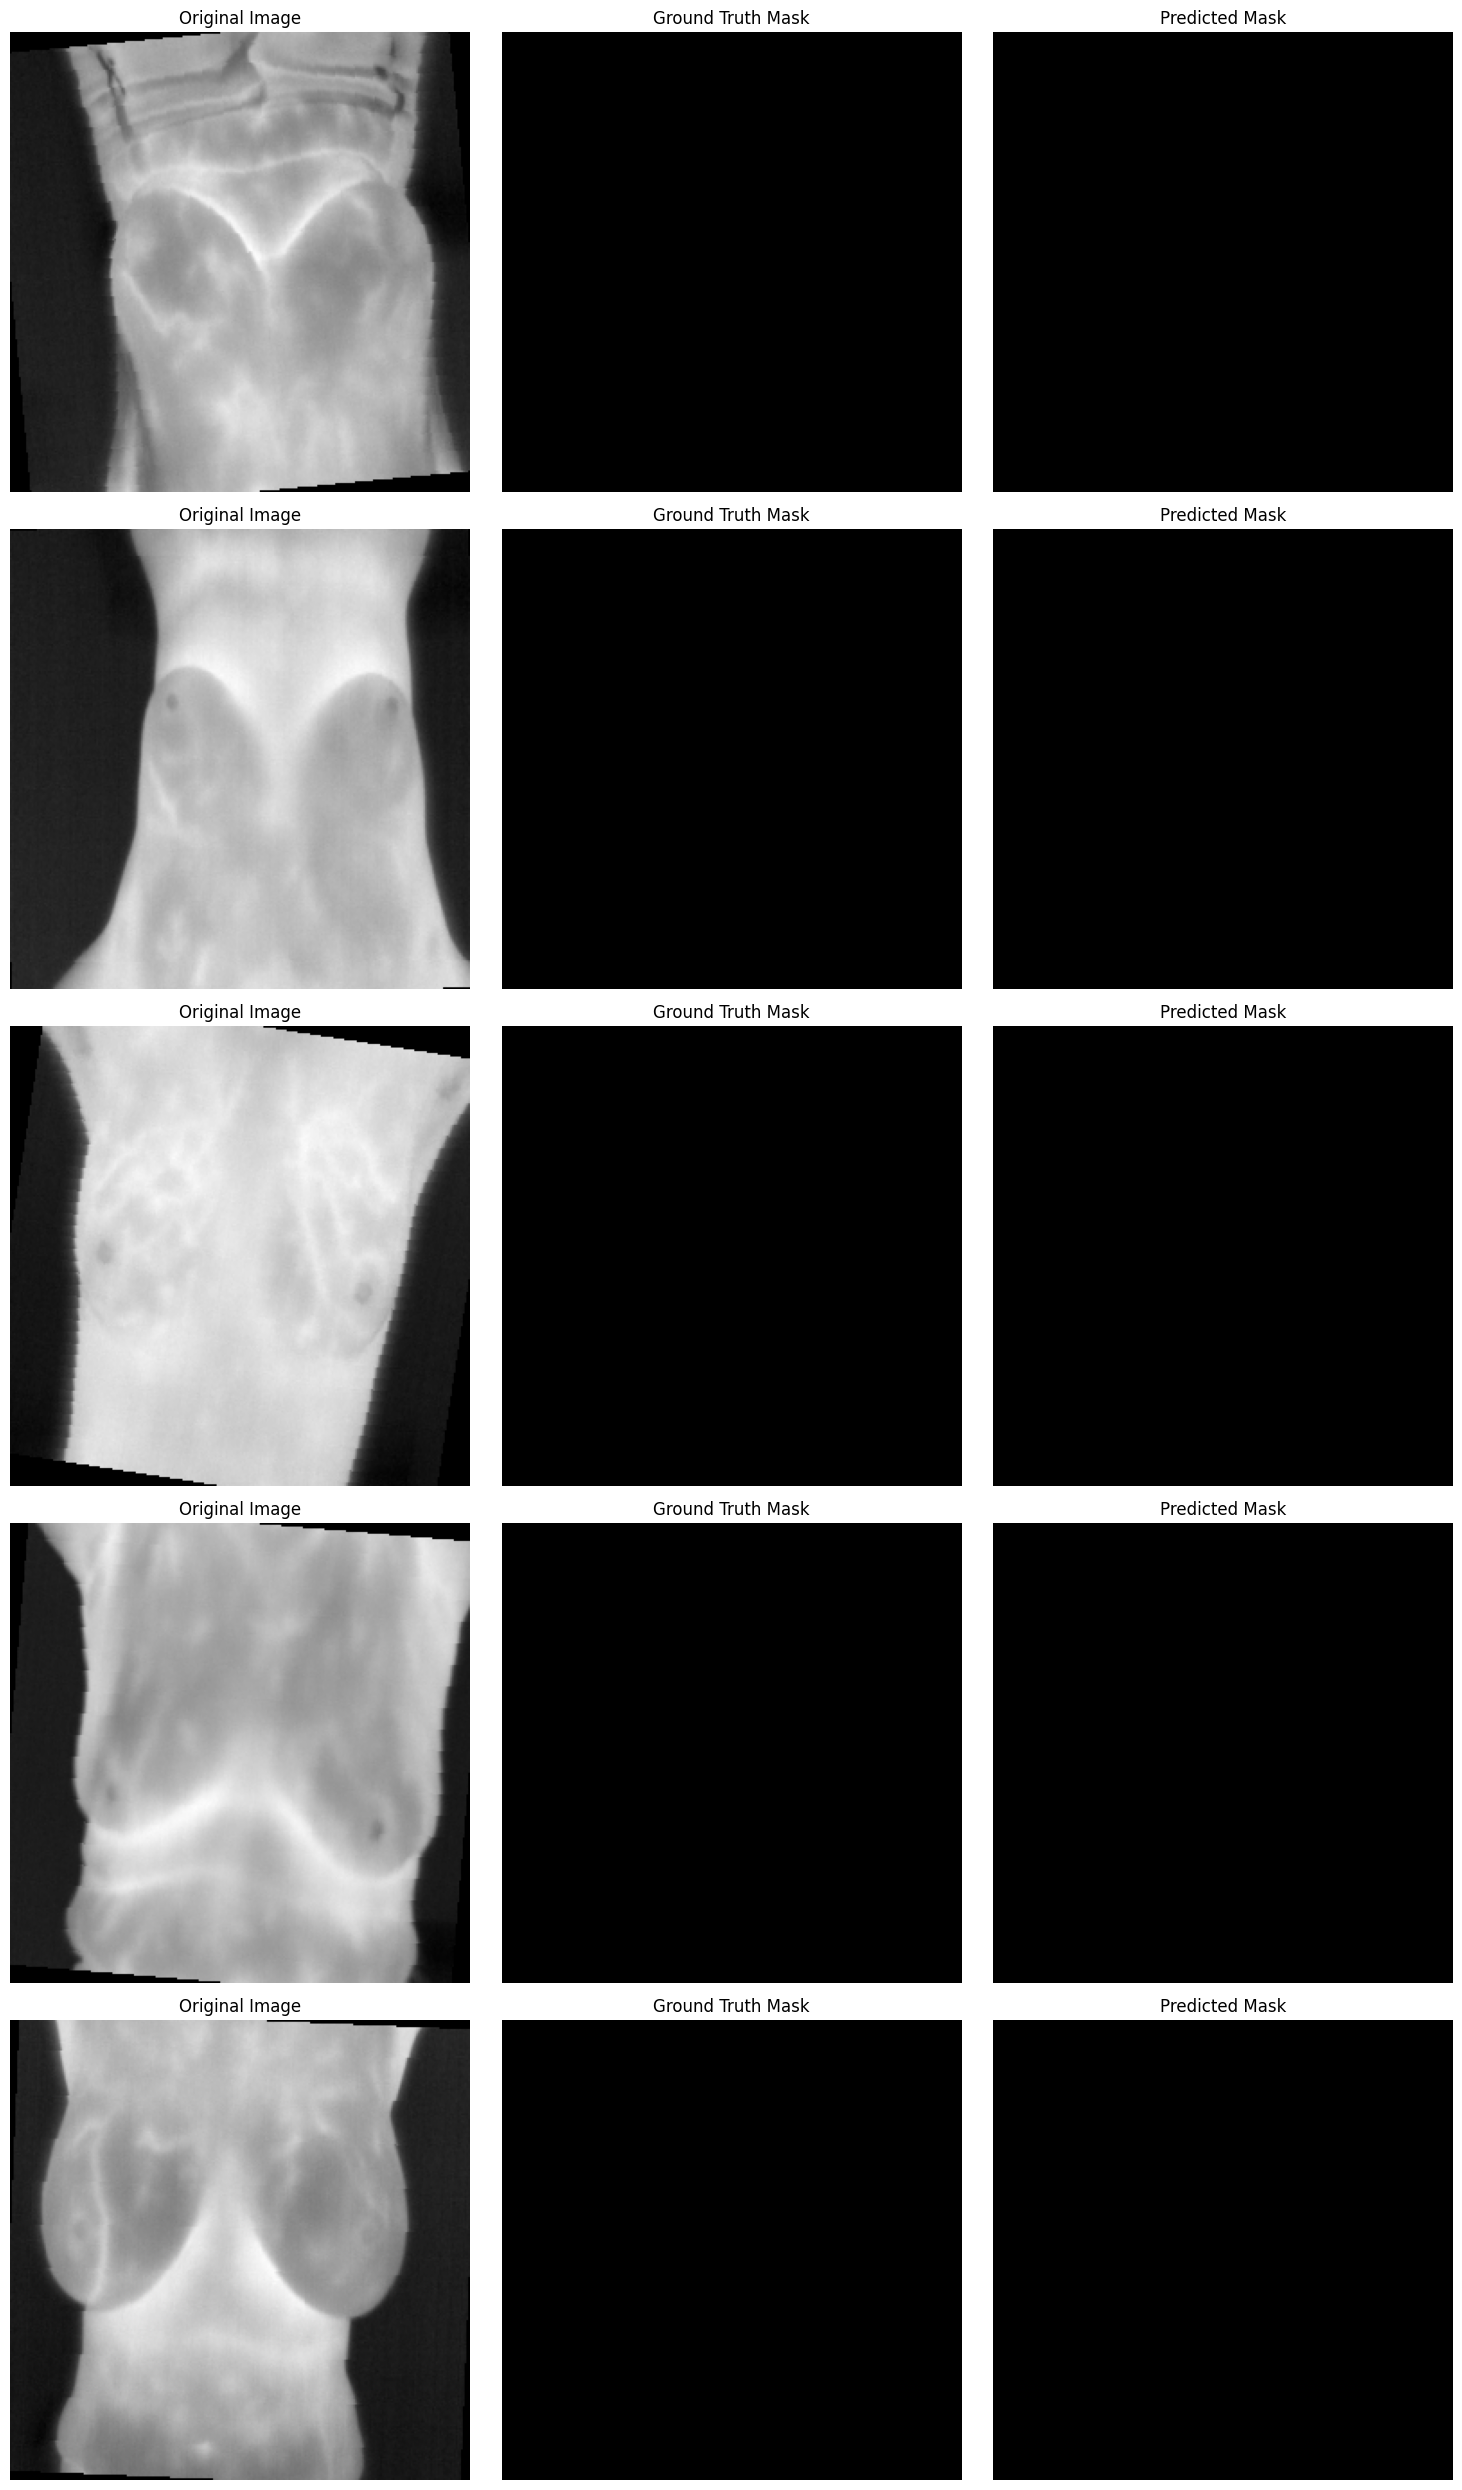

In [10]:
import random

# Randomly select samples for visualization
num_samples = 5
samples = random.sample(range(len(test_loader.dataset)), num_samples)

decoder.eval()  # Ensure the model is in evaluation mode
fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))

with torch.no_grad():
    for i, idx in enumerate(samples):
        image, mask = test_loader.dataset[idx]

        # Move the image and mask to the same device as the model
        image = image.to(device).unsqueeze(0)  # Add batch dimension
        mask = mask.to(device).unsqueeze(0)

        # Extract features using the encoder
        tf_features = encoder(image.permute(0, 2, 3, 1).cpu().numpy())

        # Convert TensorFlow tensors to PyTorch tensors correctly
        torch_features = [torch.from_numpy(f.numpy()).permute(0, 3, 1, 2).to(device) for f in tf_features]

        # Get model prediction
        prediction = decoder(torch_features)
        prediction = torch.sigmoid(prediction).squeeze().cpu().numpy()  # Apply sigmoid and remove batch dimension

        # Threshold the prediction
        prediction_binary = (prediction > 0.5).astype(int)

        # Plot the original image, ground truth, and prediction
        axes[i, 0].imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(prediction_binary, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [11]:
pip install torchsummary

In [12]:
from torchsummary import summary

# Assuming `decoder` is your model and it is already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
decoder.to(device)

# Provide the input shape as (C, H, W)
input_shape = (256, 256)  # Height and Width
summary(decoder, input_size=(256, 256, input_shape[0]))

ValueError: not enough values to unpack (expected 3, got 2)